# Détection de faux billets avec Python
### 
<figure>
   <img src="./images/ONCFM logo.png" >
</figure>

## [Cahier des charges](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/DAN-P10-cdc-detection-faux-billets.pdf)
## Sommaire
 - [1. Préparation](#1)
   - [1.1 Importation des librairies](#1.1)
   - [1.2 Importation des bases de données](#1.2)
   - [1.3 Aperçu des données](#1.3)
   - [1.4 Recherche de potentiels "outliers" dans les données](#1.4)
 - [2. Régression linéaire](#2)
   - [2.1 Préparation du modèle](#2.1)
   - [2.2 Prédiction des valeurs manquantes](#2.2)
   - [2.3 DataFrame complète avec les données manquantes](#2.3)
 - [3. Régression logistique](#3)
   - [3.1 Préparation du modèle](#3.1)
   - [3.2 Matrice de confusion](#3.2)
   - [3.3 Prédictions sur le test dataset](#3.3) 
 - [4. K-Means clustering for classification](#4)
   - [4.1 Préparation du modèle](4.1)
   - [4.2 Matrice de confusion](#4.2)
   - [4.3 Prédictions sur le test dataset](#4.3)
 - [5. Application finale](#5)

<a name="1"></a>
## 1. Préparation
<a name="1.1"></a>
### 1.1 Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


<a name="1.2"></a>
### 1.2 Importation des bases de données

In [2]:
data = pd.read_csv('C:\\Users\\axeli\\OneDrive\\Desktop\\Projet 10\\billets.csv', sep=';')
data_test = pd.read_csv('C:\\Users\\axeli\\OneDrive\\Desktop\\Projet 10\\billets_production.csv', sep=',')

test3 = pd.read_csv('C:\\Users\\axeli\\OneDrive\\Desktop\\Projet 10\\billets_test.csv', sep=',')


Nous séparons les faux billets des vrais billets en deux bases de données :

In [3]:
data_true = data[data['is_genuine'] == True]
data_false = data[data['is_genuine'] == False]

<a name="1.3"></a>
### 1.3 Aperçu des données

Dimensions de nos deux bases de données :

In [4]:
print('Vrais billets :', data_true.shape)
print('Faux billets :', data_false.shape)

Vrais billets : (1000, 7)
Faux billets : (500, 7)


Aperçu de la DataFrame des vrais billets :

In [5]:
display(data_true)
print(data_true.info())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,4.26,2.83,113.20
996,True,172.16,103.72,103.61,4.30,2.72,113.51
997,True,171.78,103.38,104.22,4.23,3.07,113.77
998,True,171.44,103.96,103.92,3.68,2.89,113.21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1000 non-null   bool   
 1   diagonal      1000 non-null   float64
 2   height_left   1000 non-null   float64
 3   height_right  1000 non-null   float64
 4   margin_low    971 non-null    float64
 5   margin_up     1000 non-null   float64
 6   length        1000 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 55.7 KB
None


Aperçu de la DataFrame des faux billets :

In [6]:
display(data_false)
print(data_false.info())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    500 non-null    bool   
 1   diagonal      500 non-null    float64
 2   height_left   500 non-null    float64
 3   height_right  500 non-null    float64
 4   margin_low    492 non-null    float64
 5   margin_up     500 non-null    float64
 6   length        500 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 27.8 KB
None


Nous pouvons aussi afficher une matrice de corrélation pour voir si certaines variables sont corrélées. Cela n'a pas l'air d'être le cas.

In [7]:
corrMatrix = data.corr()
display(corrMatrix)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


<a name="1.4"></a>
### 1.4 Recherche de potentiels "outliers" dans les données

In [8]:
def Outliers(i):
    """ Display un boxplot et la liste des outliers de la variable entrée """
    print()
    print("Boxplot :", i)
    boite = boxplot(data[i])
    plt.show()
    print()
    print("Liste des outliers :")
    top_points = boite["fliers"][0].get_data()[1]
    display(pd.DataFrame(data[i][data[i].isin(top_points)]).sort_values(by = i, ascending=False))


Boxplot : diagonal


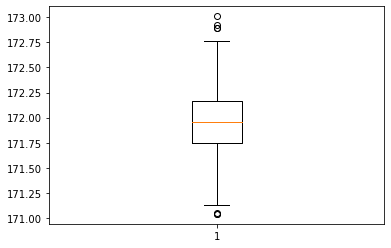


Liste des outliers :


,diagonal
1277,173.01
828,172.92
842,172.89
1022,172.89
1388,171.05
729,171.04
1142,171.04



Boxplot : height_left


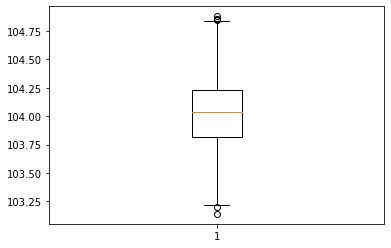


Liste des outliers :


,height_left
1090,104.88
0,104.86
1150,104.86
1382,104.85
224,103.20
292,103.14



Boxplot : height_right


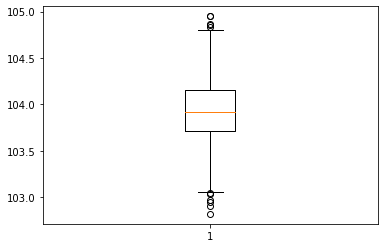


Liste des outliers :


,height_right
0,104.95
1484,104.95
1199,104.87
1321,104.86
1331,104.83
761,103.04
77,103.03
176,102.97
193,102.95
522,102.91



Boxplot : margin_low


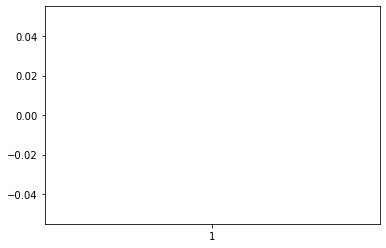


Liste des outliers :


,margin_low



Boxplot : margin_up


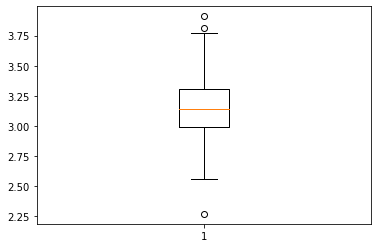


Liste des outliers :


,margin_up
1029,3.91
1270,3.81
664,2.27



Boxplot : length


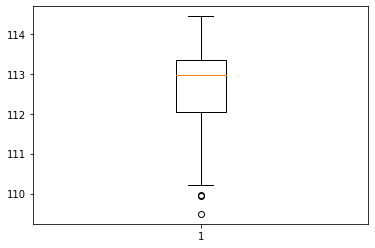


Liste des outliers :


,length
1355,109.97
1453,109.93
1082,109.49


In [9]:
for column in data.columns[1:]:
   Outliers(column)

Création de DataFrames séparant les données complètes des données ayant 'margin_low' == null

In [10]:
data_true_null = data_true[data_true["margin_low"].isnull()]
data_false_null = data_false[data_false["margin_low"].isnull()]

data_true_without_null = data_true[data_true["margin_low"].notnull()]
data_false_without_null = data_false[data_false["margin_low"].notnull()]

<a name="2"></a>
## 2. Régression linéaire
Nous allons prédire les valeurs manquantes de notre base de données grâce à une régression linéaire.
<a name="2.1"></a>
### 2.1 Préparation du modèle
Visualisation des données

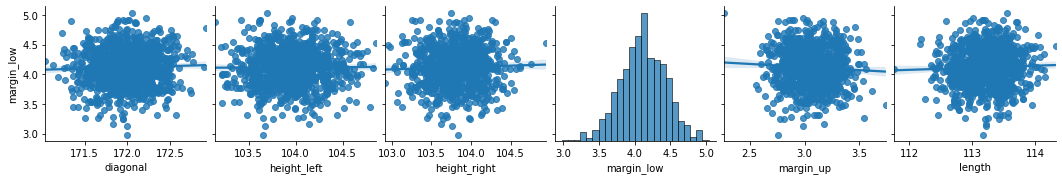

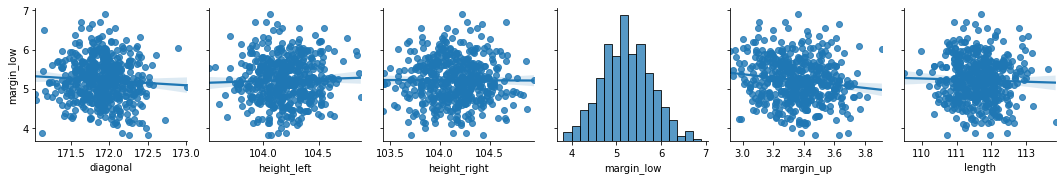

In [11]:
sns.pairplot(data_true_without_null, x_vars=["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"], y_vars="margin_low", kind='reg')
sns.pairplot(data_false_without_null, x_vars=["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"], y_vars="margin_low", kind='reg')

Attribution de X et y

In [12]:
feature_cols = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

X_true = data_true_without_null[feature_cols]
X_false = data_false_without_null[feature_cols]

y_true = data_true_without_null['margin_low']
y_false = data_false_without_null['margin_low']

Séparation des données en données de training et données de test

In [13]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X_true, y_true)
X_false_train, X_false_test, y_false_train, y_false_test = train_test_split(X_false, y_false)

Apprentissage du modèle

In [14]:
linreg_true = LinearRegression()
linreg_false = LinearRegression()

linreg_true.fit(X_true_train, y_true_train)
linreg_false.fit(X_false_train, y_false_train)

LinearRegression()

Coefficients :

In [15]:
print(linreg_true.intercept_)
print(linreg_false.intercept_)

print(linreg_true.coef_)
print(linreg_false.coef_)

zip(feature_cols, linreg_true.coef_)
zip(feature_cols, linreg_false.coef_)

-12.250180631171819
0.6938129268197732
[ 0.03021133  0.03927569  0.02686351 -0.10718037  0.04098337]
[-0.01289936  0.13577065 -0.03764068 -0.47608171 -0.01702752]


Prédiction du modèle entraîné sur les données de test :

In [16]:
y_true_pred = linreg_true.predict(X_true_test)
y_false_pred = linreg_false.predict(X_false_test)

print(y_true_pred)
print(y_false_pred)

[4.15717401 4.10516164 4.12966642 4.11072905 4.12815788 4.15812049
 4.17524055 4.12946652 4.13238378 4.0728628  4.09121141 4.12064279
 4.0904931  4.15962409 4.1225609  4.15062404 4.14834772 4.15748689
 4.09175836 4.15104981 4.15464904 4.12673882 4.07144978 4.15479545
 4.10916438 4.13102464 4.11836194 4.08005374 4.1559603  4.0885584
 4.09387688 4.12277774 4.17043924 4.11888116 4.11933973 4.13281051
 4.10180178 4.13870414 4.12132887 4.11833245 4.09156391 4.13081783
 4.06612361 4.16571819 4.16374311 4.15293641 4.12266236 4.09760604
 4.07565019 4.11462568 4.12950929 4.03838667 4.09507255 4.11510665
 4.14350507 4.16752296 4.12012497 4.10773691 4.16391374 4.13341181
 4.10600443 4.14359379 4.12147228 4.10633023 4.1080795  4.22962305
 4.14971758 4.10510961 4.07204199 4.11350275 4.14151544 4.11698914
 4.19238611 4.10160802 4.17546051 4.10388942 4.17949106 4.15646717
 4.10081615 4.13535417 4.14804069 4.14799302 4.13372456 4.12251558
 4.09900664 4.03090179 4.11799344 4.15783743 4.13112635 4.14481

Évaluation du modèle

In [17]:
print()
print('Vrais billets :')
print(metrics.mean_absolute_error(y_true_test, y_true_pred))
print(metrics.mean_squared_error(y_true_test, y_true_pred))
print(np.sqrt(metrics.mean_squared_error(y_true_test, y_true_pred)))

print()
print('Faux billets :')
print(metrics.mean_absolute_error(y_false_test, y_false_pred))
print(metrics.mean_squared_error(y_false_test, y_false_pred))
print(np.sqrt(metrics.mean_squared_error(y_false_test, y_false_pred)))


Vrais billets :
0.2590959006270132
0.10507828492150773
0.3241578086696474

Faux billets :
0.44005109197640685
0.2876735489545403
0.5363520755572223


<a name="2.2"></a>
### 2.2 Prédiction des valeurs manquantes

In [18]:
print()
print('Vrais billets :')

data_true_pred = data_true_null[feature_cols]
pred_true = linreg_true.predict(data_true_pred)
print(pred_true)

data_true2 = data_true.copy(deep=True)
data_true2.loc[data_true2['margin_low'].isnull(), 'margin_low'] = pred_true


print()
print('Faux billets :')

data_false_pred = data_false_null[feature_cols]
pred_false = linreg_false.predict(data_false_pred)
print(pred_false)

data_false2 = data_false.copy(deep=True)
data_false2.loc[data_false2['margin_low'].isnull(), 'margin_low'] = pred_false


Vrais billets :
[4.07791493 4.12796782 4.13367981 4.04349548 4.10782598 4.08179461
 4.10591714 4.13158953 4.11207169 4.09730435 4.13773727 4.18060604
 4.16347428 4.06320214 4.13233305 4.17205573 4.10834484 4.08585392
 4.1168816  4.14187573 4.17446802 4.15682186 4.18054749 4.11478763
 4.14629336 4.17734886 4.10267737 4.09361697 4.15257597]

Faux billets :
[5.27319027 5.30991706 5.36221457 5.4654569  5.16287502 5.14522706
 5.10858784 5.2681253 ]


<a name="2.3"></a>
### 2.3 DataFrame complète avec les données manquantes

In [19]:
frames = (data_true2, data_false2)
data2 = pd.concat(frames)

display(data2)
print(data2.info())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB
None


<a name="3"></a>
## 3. Régression logistique
<a name="3.1"></a>
### 3.1 Préparation du modèle
Attribution de X et y

In [20]:
feature_cols_log = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_log = data2[feature_cols_log]

data2['is_genuine'] = data2['is_genuine'].astype('category')
y_log = data2['is_genuine'].cat.codes

Séparation des données en données de training et données de test

In [21]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.3, random_state=0)

Apprentissage du modèle

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train_log, y_train_log)

LogisticRegression()

Prédiction du modèle entraîné sur les données de test

In [23]:
y_pred_log = logreg.predict(X_test_log)
print(y_pred_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test_log)))

[1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1
 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1
 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0
 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1
 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0
 0 0 0 0 0 1]
Accuracy of logistic regression classifier on test set: 1.00


<a name="3.2"></a>
### 3.2 Matrice de confusion

In [24]:
matrice_de_confusion_log = confusion_matrix(y_test_log, y_pred_log)
display(pd.DataFrame(matrice_de_confusion_log))

print(classification_report(y_test_log, y_pred_log))

,0,1
0,156,1
1,0,293


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       157
           1       1.00      1.00      1.00       293

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



<a name="3.3"></a>
### 3.3 Prédictions sur le test dataset

In [25]:
display(data_test)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [26]:
data_test2 = data_test[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

pred_log = logreg.predict(data_test2)

print(pred_log) # 0 == faux billet, 1 == vrai billet

[0 0 0 1 1]


<a name="4"></a>
## 4. K-MEANS CLUSTERING FOR CLASSIFICATION
<a name="4.1"></a>
### 4.1 Préparation du modèle
Attribution de X et y

In [27]:
feature_cols_km = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_km = data2[feature_cols_km]

y_km = data2['is_genuine'].cat.codes

Séparation des données en données d'entraînement et données de test

In [28]:
X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(X_km, y_km, test_size=0.3, random_state=0)

Entraînement du modèle

In [29]:
kmeans = KMeans(n_clusters=2, random_state =42)
kmeans.fit(X_train_km, y_train_km)

KMeans(n_clusters=2, random_state=42)

Prédiction du modèle sur les données de test

In [30]:
y_pred_km = kmeans.predict(X_test_km)
print(y_pred_km)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_km, y_test_km)))

[0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1
 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1
 1 1 1 1 1 0]
Accuracy of logistic regression classifier on test set: 1.00


<a name="4.2"></a>
### 4.2 Matrice de confusion

In [31]:
matrice_de_confusion_km = confusion_matrix(y_test_km, y_pred_km)
display(pd.DataFrame(matrice_de_confusion_log))

print(classification_report(y_test_km, y_pred_km))

,0,1
0,156,1
1,0,293


              precision    recall  f1-score   support

           0       0.01      0.02      0.01       157
           1       0.00      0.00      0.00       293

    accuracy                           0.01       450
   macro avg       0.01      0.01      0.01       450
weighted avg       0.00      0.01      0.00       450



<a name="4.3"></a>
### 4.3 Prédictions sur le test dataset

In [32]:
pred_km = kmeans.predict(data_test2)

print(pred_km) # 0 == vrai billet, 1 == faux billet

[1 1 1 0 0]


Centroïdes des clusters :

In [33]:
print(kmeans.cluster_centers_)

[[171.9764779  103.95455801 103.81372928   4.13068225   3.05947514
  113.18551105]
 [171.89174847 104.19199387 104.14610429   5.24300726   3.34273006
  111.58306748]]


<a name="5"></a>
## 5. Application finale

In [34]:

def logistic_regression(matrix):
    """Réalise une régression logistique sur une matrice entrée"""
    print("Vérification des billets par Régression Logistique...")
    print()
    matrix2 = matrix[feature_cols_log]
    prediction = logreg.predict(matrix2)
    matrix['Prédiction'] = prediction
    matrix.loc[matrix.Prédiction == 0, "Prédiction"] = "Faux billet"
    matrix.loc[matrix.Prédiction == 1, "Prédiction"] = "Vrai billet"
    return matrix


def k_means_classification(matrix):
    """Réalise une classification via K-Means d'une matrice entrée"""
    print("Vérification des billets par Classification via K-Means...")
    print()
    matrix2 = matrix[feature_cols_km]
    prediction = kmeans.predict(matrix2)
    matrix['Prédiction'] = prediction
    matrix.loc[matrix.Prédiction == 0, "Prédiction"] = "Vrai billet"
    matrix.loc[matrix.Prédiction == 1, "Prédiction"] = "Faux billet"
    return matrix



In [35]:
data_test_reg = data_test.copy(deep=True)
data_test_km = data_test.copy(deep=True)

In [36]:
logistic_regression(test3)

Vérification des billets par Régression Logistique...



,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prédiction
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,Vrai billet
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,Faux billet
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,Vrai billet
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,Faux billet
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,Faux billet


In [37]:
k_means_classification(test3)

Vérification des billets par Classification via K-Means...



,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prédiction
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,Vrai billet
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,Faux billet
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,Vrai billet
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,Faux billet
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,Faux billet
